# CDO - Climate Data Operators

CDO User Guide https://code.mpimet.mpg.de/projects/cdo/embedded/cdo.pdf

CDO Python bindings introduction https://code.mpimet.mpg.de/attachments/download/18824/cdo-bindings.pdf

### Table of contents

- About CDO
- Import CDO module
- Show CDO version
- Set temporary directory
- Delete temporay files
- List CDO operators
- List all operators starting with 'sel'
- Show information about an operator
- Turn debugging on/off
- Display information about the file content
- Show information about the variables value range, times, levels in more detail
- Copy file
- Select variables
- Select timesteps
- Operator chaining
- Select a sub-region
- Compute the field mean
- Assign data to variable
- Remapping
- Remap data to grid of another file
- Create a land-sea mask
- Masking data
- Delete temporary files

<br>


## About CDO

See also https://code.mpimet.mpg.de/projects/cdo/wiki

CDO is a large tool set for working on climate and NWP model data. NetCDF 3/4, GRIB 1/2 including SZIP (or AEC) and JPEG compression, EXTRA, SERVICE and IEG are supported as IO-formats. Apart from that CDO can be used to analyse any kind of gridded data not related to climate science. CDO has very small memory requirements and can process files larger than the physical memory.

CDO is open source and released under the terms of the GNU General Public License v2 (GPL).

<br>

## Import CDO module

Import the CDO module and set cdo to Cdo() which makes writing a little easier.

In [1]:
from cdo import *

cdo = Cdo()

<br>

## Show CDO version

python-cdo version:

In [8]:
print(cdo.__version__())


1.5.4


Based on CDO version:

In [3]:
print(cdo.version())

2.0.3


<br>

## Set temporary directory

Set another directory for storing tempfiles with a constructor option and remove anything left in there when you experienced a crash or something like this

In [9]:
tempPath = './tmp/'
cdo = Cdo(tempdir=tempPath)

<br>

## Delete temporary files

In [ ]:
cdo.cleanTempDir()

<br>

## List CDO operators

More than 800 operators are available.

In [5]:
# list of operators
cdo.operators

{'abs': 1,
 'acos': 1,
 'add': 1,
 'addc': 1,
 'addtrend': 1,
 'adipot': 1,
 'adisit': 1,
 'aexpr': 1,
 'aexprf': 1,
 'after': 1,
 'afterburner': 1,
 'anomaly': 1,
 'ap2hl': 1,
 'ap2hlx': 1,
 'ap2pl': 1,
 'ap2pl_lp': 1,
 'ap2plx': 1,
 'ap2plx_lp': 1,
 'apply': 1,
 'arg': 1,
 'asin': 1,
 'atan': 1,
 'atan2': 1,
 'bandpass': 1,
 'bottomvalue': 1,
 'boxavg': 1,
 'cat': 1,
 'cdiread': 0,
 'cdiwrite': 1,
 'changemulti': 1,
 'chcode': 1,
 'chlevel': 1,
 'chlevelc': 1,
 'chlevelv': 1,
 'chltype': 1,
 'chname': 1,
 'chparam': 1,
 'chtabnum': 1,
 'chunit': 1,
 'chvar': 1,
 'cloudlayer': 1,
 'cmor': 0,
 'cmorlite': 1,
 'codetab': 0,
 'collgrid': 1,
 'complextopol': 2,
 'complextorect': 2,
 'conj': 1,
 'consecsum': 1,
 'consects': 1,
 'const': 1,
 'contour': 1,
 'conv_cmor_table': 0,
 'copy': 1,
 'cos': 1,
 'coshill': 1,
 'dayadd': 1,
 'dayavg': 1,
 'daycount': 1,
 'daydiv': 1,
 'daymax': 1,
 'daymean': 1,
 'daymin': 1,
 'daymul': 1,
 'daypctl': 1,
 'dayrange': 1,
 'daystd': 1,
 'daystd1': 1,
 'd

In [ ]:
# get the number of existing operators of CDO

**Excercise** To get the first 50 operators you can do what?

<br>

## List all operators starting with 'sel'

Use list comprehension


In [10]:
[key for key, value in cdo.operators.items() if key.startswith('sel')]

['selall',
 'selcircle',
 'selcode',
 'seldate',
 'selday',
 'select',
 'selgrid',
 'selgridcell',
 'selgridname',
 'selhour',
 'selindex',
 'selindexbox',
 'sellevel',
 'sellevidx',
 'sellonlatbox',
 'selltype',
 'selmon',
 'selmonth',
 'selmulti',
 'selname',
 'seloperator',
 'selparam',
 'selrec',
 'selseas',
 'selseason',
 'selsmon',
 'selstdname',
 'seltabnum',
 'seltime',
 'seltimeidx',
 'seltimestep',
 'selvar',
 'selyear',
 'selyearidx',
 'selzaxis',
 'selzaxisname']

## Turn debugging on/off

Use the debug method of CDO to turn on or off debugging.


In [ ]:
cdo.debug = True

cdo.debug = False

<br>

## Show information about file content


In [2]:
!pwd

/home/k/k202015/summer-school-2022/notebooks/files_and_tools


In [3]:
cdo.sinfon(input='../../data/rectilinear_grid_2D.nc')

['File format : NetCDF',
 '-1 : Institut Source   T Steptype Levels Num    Points Num Dtype : Parameter name',
 '1 : unknown  unknown  v instant       1   1     18432   1  F32  : tsurf',
 '2 : unknown  unknown  v instant       1   1     18432   1  F32  : precip',
 '3 : unknown  unknown  v instant       1   1     18432   1  F32  : u10',
 '4 : unknown  unknown  v instant       1   1     18432   1  F32  : v10',
 '5 : unknown  unknown  v instant       1   1     18432   1  F32  : qvi',
 '6 : unknown  unknown  v instant       1   1     18432   1  F32  : slp',
 'Grid coordinates :',
 '1 : gaussian                 : points=18432 (192x96)',
 'lon : -180 to 178.125 by 1.875 degrees_east  circular',
 'lat : 88.57217 to -88.57217 degrees_north',
 'Vertical coordinates :',
 '1 : surface                  : levels=1',
 'Time coordinate :',
 'time : 40 steps',
 'RefTime =  2001-01-01 00:00:00  Units = hours  Calendar = standard',
 'YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM

<br>

## Display information about the file content


In [ ]:
infile = '../data/rectilinear_grid_2D.nc'

#cdo.sinfon(input=infile)

In comparison to xarray's dataset information.

In [5]:
import xarray as xr

ds = xr.open_dataset('../../data/rectilinear_grid_2D.nc')

print(ds.info())

xarray.Dataset {
dimensions:
	lon = 192 ;
	lat = 96 ;
	time = 40 ;

variables:
	float64 lon(lon) ;
		lon:standard_name = longitude ;
		lon:long_name = longitude ;
		lon:units = degrees_east ;
		lon:axis = X ;
	float64 lat(lat) ;
		lat:standard_name = latitude ;
		lat:long_name = latitude ;
		lat:units = degrees_north ;
		lat:axis = Y ;
	datetime64[ns] time(time) ;
		time:standard_name = time ;
	float32 tsurf(time, lat, lon) ;
		tsurf:long_name = surface temperature ;
		tsurf:units = K ;
		tsurf:code = 169 ;
		tsurf:table = 128 ;
		tsurf:grid_type = gaussian ;
	float32 precip(time, lat, lon) ;
		precip:long_name = total precipitation ;
		precip:units = kg/m^2s ;
		precip:code = 4 ;
		precip:table = 128 ;
		precip:grid_type = gaussian ;
	float32 u10(time, lat, lon) ;
		u10:long_name = 10m u-velocity ;
		u10:units = m/s ;
		u10:code = 165 ;
		u10:table = 128 ;
		u10:grid_type = gaussian ;
	float32 v10(time, lat, lon) ;
		v10:long_name = 10m v-velocity ;
		v10:units = m/s ;
		v10:code = 16

<br>

## Show information about the variables value range, times, levels in more detail

In [6]:
cdo.infon(input='../../data/rectilinear_grid_2D.nc')

['-1 :       Date     Time   Level Gridsize    Miss :     Minimum        Mean     Maximum : Parameter name',
 '1 : 2001-01-01 00:00:00       0    18432       0 :      221.79      276.76      313.94 : tsurf',
 '2 : 2001-01-01 00:00:00       0    18432       0 :  1.4714e-18  2.7047e-05  0.00098652 : precip',
 '3 : 2001-01-01 00:00:00       0    18432       0 :     -21.745    -0.19579      26.105 : u10',
 '4 : 2001-01-01 00:00:00       0    18432       0 :     -25.935    -0.23724      24.625 : v10',
 '5 : 2001-01-01 00:00:00       0    18432       0 :     0.32495      17.897      66.040 : qvi',
 '6 : 2001-01-01 00:00:00       0    18432       0 :      96715.  1.0094e+05  1.0536e+05 : slp',
 '7 : 2001-01-01 06:00:00       0    18432       0 :      221.39      276.85      318.76 : tsurf',
 '8 : 2001-01-01 06:00:00       0    18432       0 :  1.5052e-18  2.7256e-05   0.0012521 : precip',
 '9 : 2001-01-01 06:00:00       0    18432       0 :     -21.440   -0.062360      26.679 : u10',
 '10 : 2

<br>

## Copy file

Copy the input file to outfile.nc and change the data precision from float32 to float64.

In [ ]:
cdo.copy(input='../data/rectilinear_grid_2D.nc', options='-b F64', output='outfile.nc')
cdo.sinfon(input='outfile.nc')

<br>

To make things easier for us, we define the variables infile and outfile for the input and output files.


In [7]:
infile  = '../../data/rectilinear_grid_2D.nc'
outfile = 'outfile.nc'

<br>

## Select variables


In [8]:
cdo.selvar('tsurf', input=infile, output=outfile)
cdo.sinfon(input=outfile)

['File format : NetCDF',
 '-1 : Institut Source   T Steptype Levels Num    Points Num Dtype : Parameter name',
 '1 : unknown  unknown  v instant       1   1     18432   1  F32  : tsurf',
 'Grid coordinates :',
 '1 : gaussian                 : points=18432 (192x96)',
 'lon : -180 to 178.125 by 1.875 degrees_east  circular',
 'lat : 88.57217 to -88.57217 degrees_north',
 'Vertical coordinates :',
 '1 : surface                  : levels=1',
 'Time coordinate :',
 'time : 40 steps',
 'RefTime =  2001-01-01 00:00:00  Units = hours  Calendar = standard',
 'YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss',
 '2001-01-01 00:00:00  2001-01-01 06:00:00  2001-01-01 12:00:00  2001-01-01 18:00:00',
 '2001-01-02 00:00:00  2001-01-02 06:00:00  2001-01-02 12:00:00  2001-01-02 18:00:00',
 '2001-01-03 00:00:00  2001-01-03 06:00:00  2001-01-03 12:00:00  2001-01-03 18:00:00',
 '2001-01-04 00:00:00  2001-01-04 06:00:00  2001-01-04 12:00:00  2001-01-04 18:00:00',
 '2001-01-

In [9]:
cdo.selvar('u10,v10', input=infile, output=outfile)
cdo.sinfon(input=outfile)

['File format : NetCDF',
 '-1 : Institut Source   T Steptype Levels Num    Points Num Dtype : Parameter name',
 '1 : unknown  unknown  v instant       1   1     18432   1  F32  : u10',
 '2 : unknown  unknown  v instant       1   1     18432   1  F32  : v10',
 'Grid coordinates :',
 '1 : gaussian                 : points=18432 (192x96)',
 'lon : -180 to 178.125 by 1.875 degrees_east  circular',
 'lat : 88.57217 to -88.57217 degrees_north',
 'Vertical coordinates :',
 '1 : surface                  : levels=1',
 'Time coordinate :',
 'time : 40 steps',
 'RefTime =  2001-01-01 00:00:00  Units = hours  Calendar = standard',
 'YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss',
 '2001-01-01 00:00:00  2001-01-01 06:00:00  2001-01-01 12:00:00  2001-01-01 18:00:00',
 '2001-01-02 00:00:00  2001-01-02 06:00:00  2001-01-02 12:00:00  2001-01-02 18:00:00',
 '2001-01-03 00:00:00  2001-01-03 06:00:00  2001-01-03 12:00:00  2001-01-03 18:00:00',
 '2001-01-04 00:00:00  20

<br>

## Select timesteps

Select timestep 1 and 10:

In [10]:
cdo.seltimestep('1,10', input=infile, output=outfile)
cdo.sinfon(input=outfile)

['File format : NetCDF',
 '-1 : Institut Source   T Steptype Levels Num    Points Num Dtype : Parameter name',
 '1 : unknown  unknown  v instant       1   1     18432   1  F32  : tsurf',
 '2 : unknown  unknown  v instant       1   1     18432   1  F32  : precip',
 '3 : unknown  unknown  v instant       1   1     18432   1  F32  : u10',
 '4 : unknown  unknown  v instant       1   1     18432   1  F32  : v10',
 '5 : unknown  unknown  v instant       1   1     18432   1  F32  : qvi',
 '6 : unknown  unknown  v instant       1   1     18432   1  F32  : slp',
 'Grid coordinates :',
 '1 : gaussian                 : points=18432 (192x96)',
 'lon : -180 to 178.125 by 1.875 degrees_east  circular',
 'lat : 88.57217 to -88.57217 degrees_north',
 'Vertical coordinates :',
 '1 : surface                  : levels=1',
 'Time coordinate :',
 'time : 2 steps',
 'RefTime =  2001-01-01 00:00:00  Units = hours  Calendar = standard',
 'YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-

Select timestep 1 to 10:

In [11]:
cdo.seltimestep('1/10', input=infile, output=outfile)
cdo.sinfon(input=outfile)

['File format : NetCDF',
 '-1 : Institut Source   T Steptype Levels Num    Points Num Dtype : Parameter name',
 '1 : unknown  unknown  v instant       1   1     18432   1  F32  : tsurf',
 '2 : unknown  unknown  v instant       1   1     18432   1  F32  : precip',
 '3 : unknown  unknown  v instant       1   1     18432   1  F32  : u10',
 '4 : unknown  unknown  v instant       1   1     18432   1  F32  : v10',
 '5 : unknown  unknown  v instant       1   1     18432   1  F32  : qvi',
 '6 : unknown  unknown  v instant       1   1     18432   1  F32  : slp',
 'Grid coordinates :',
 '1 : gaussian                 : points=18432 (192x96)',
 'lon : -180 to 178.125 by 1.875 degrees_east  circular',
 'lat : 88.57217 to -88.57217 degrees_north',
 'Vertical coordinates :',
 '1 : surface                  : levels=1',
 'Time coordinate :',
 'time : 10 steps',
 'RefTime =  2001-01-01 00:00:00  Units = hours  Calendar = standard',
 'YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM

<br>

## Operator chaining

Operators with a fixed number of input files (streams) and only one output file can be combined. The input parameters must begin with an '-' and they will be executed from right to left.

Select the variables u10 and v10 and then select the first 10 timesteps:

In [12]:
cdo.seltimestep('1/10', input='-selvar,u10,v10 '+infile, output=outfile)
cdo.sinfon(input=outfile)

['File format : NetCDF',
 '-1 : Institut Source   T Steptype Levels Num    Points Num Dtype : Parameter name',
 '1 : unknown  unknown  v instant       1   1     18432   1  F32  : u10',
 '2 : unknown  unknown  v instant       1   1     18432   1  F32  : v10',
 'Grid coordinates :',
 '1 : gaussian                 : points=18432 (192x96)',
 'lon : -180 to 178.125 by 1.875 degrees_east  circular',
 'lat : 88.57217 to -88.57217 degrees_north',
 'Vertical coordinates :',
 '1 : surface                  : levels=1',
 'Time coordinate :',
 'time : 10 steps',
 'RefTime =  2001-01-01 00:00:00  Units = hours  Calendar = standard',
 'YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss',
 '2001-01-01 00:00:00  2001-01-01 06:00:00  2001-01-01 12:00:00  2001-01-01 18:00:00',
 '2001-01-02 00:00:00  2001-01-02 06:00:00  2001-01-02 12:00:00  2001-01-02 18:00:00',
 '2001-01-03 00:00:00  2001-01-03 06:00:00']

Use operators and options at once to do the above sections and change the output precision:

In [13]:
cdo.seltimestep('1/10', input='-selvar,u10,v10 '+infile, options='-b F64', output=outfile)
cdo.sinfon(input=outfile)

['File format : NetCDF',
 '-1 : Institut Source   T Steptype Levels Num    Points Num Dtype : Parameter name',
 '1 : unknown  unknown  v instant       1   1     18432   1  F64  : u10',
 '2 : unknown  unknown  v instant       1   1     18432   1  F64  : v10',
 'Grid coordinates :',
 '1 : gaussian                 : points=18432 (192x96)',
 'lon : -180 to 178.125 by 1.875 degrees_east  circular',
 'lat : 88.57217 to -88.57217 degrees_north',
 'Vertical coordinates :',
 '1 : surface                  : levels=1',
 'Time coordinate :',
 'time : 10 steps',
 'RefTime =  2001-01-01 00:00:00  Units = hours  Calendar = standard',
 'YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss',
 '2001-01-01 00:00:00  2001-01-01 06:00:00  2001-01-01 12:00:00  2001-01-01 18:00:00',
 '2001-01-02 00:00:00  2001-01-02 06:00:00  2001-01-02 12:00:00  2001-01-02 18:00:00',
 '2001-01-03 00:00:00  2001-01-03 06:00:00']

<br>

## Select a sub-region

In [14]:
cdo.sellonlatbox('20,30,70,80', input='-seltimestep,1 '+infile, output=outfile)
cdo.sinfon(input=outfile)

['File format : NetCDF',
 '-1 : Institut Source   T Steptype Levels Num    Points Num Dtype : Parameter name',
 '1 : unknown  unknown  v instant       1   1        30   1  F32  : tsurf',
 '2 : unknown  unknown  v instant       1   1        30   1  F32  : precip',
 '3 : unknown  unknown  v instant       1   1        30   1  F32  : u10',
 '4 : unknown  unknown  v instant       1   1        30   1  F32  : v10',
 '5 : unknown  unknown  v instant       1   1        30   1  F32  : qvi',
 '6 : unknown  unknown  v instant       1   1        30   1  F32  : slp',
 'Grid coordinates :',
 '1 : gaussian                 : points=30 (6x5)',
 'lon : 20.625 to 30 by 1.875 degrees_east',
 'lat : 79.27056 to 71.81113 degrees_north',
 'Vertical coordinates :',
 '1 : surface                  : levels=1',
 'Time coordinate :',
 'time : 1 step',
 'RefTime =  2001-01-01 00:00:00  Units = hours  Calendar = standard',
 'YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss',
 '2001-

<br>

## Compute the field mean

Compute the mean of the horizontal field for each timestep (-> time series).

In [15]:
cdo.fldmean(input="-selname,tsurf "+infile, output='outfile.nc')
cdo.sinfon(input=outfile)

['File format : NetCDF',
 '-1 : Institut Source   T Steptype Levels Num    Points Num Dtype : Parameter name',
 '1 : unknown  unknown  v instant       1   1         1   1  F32  : tsurf',
 'Grid coordinates :',
 '1 : lonlat                   : points=1 (1x1)',
 'lon : 0 degrees_east',
 'lat : 0 degrees_north',
 'Vertical coordinates :',
 '1 : surface                  : levels=1',
 'Time coordinate :',
 'time : 40 steps',
 'RefTime =  2001-01-01 00:00:00  Units = hours  Calendar = standard',
 'YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss',
 '2001-01-01 00:00:00  2001-01-01 06:00:00  2001-01-01 12:00:00  2001-01-01 18:00:00',
 '2001-01-02 00:00:00  2001-01-02 06:00:00  2001-01-02 12:00:00  2001-01-02 18:00:00',
 '2001-01-03 00:00:00  2001-01-03 06:00:00  2001-01-03 12:00:00  2001-01-03 18:00:00',
 '2001-01-04 00:00:00  2001-01-04 06:00:00  2001-01-04 12:00:00  2001-01-04 18:00:00',
 '2001-01-05 00:00:00  2001-01-05 06:00:00  2001-01-05 12:00:00  2001-

Plot the fieldmean data:

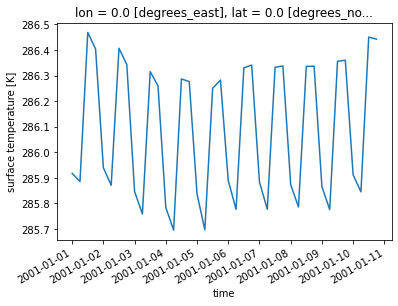

In [16]:
cdo.fldmean(input="-selname,tsurf "+infile, returnXArray='tsurf').plot()

<br>

## Assign data to variable

Assign the file variable precip to the python variable precipitation:

In [17]:
precipitation = cdo.selvar('precip', input=infile, returnXArray='precip')
print(precipitation)

<xarray.DataArray 'precip' (time: 40, lat: 96, lon: 192)>
[737280 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 ... 2001-01-10T18:00:00
  * lon      (lon) float64 -180.0 -178.1 -176.2 -174.4 ... 174.4 176.2 178.1
  * lat      (lat) float64 88.57 86.72 84.86 83.0 ... -83.0 -84.86 -86.72 -88.57
Attributes:
    long_name:      total precipitation
    units:          kg/m^2s
    code:           4
    table:          128
    CDI_grid_type:  gaussian


Print the value of the first timestep, first latitude, first longitude:

In [18]:
print(precipitation.values[0,0,0])

1.8439023e-06


Compute the fieldmean:

In [19]:
tsurf_fldmean = cdo.fldmean(input=infile, returnXArray='tsurf')
print(tsurf_fldmean.values[0:10,0,0])

[285.91788 285.8857  286.46826 286.4037  285.9395  285.8711  286.40665
 286.34302 285.84647 285.7593 ]


<br>

## Remapping

Interpolate the data of input file to a new grid using the bilinear interpolation method.

For the ease of use, we select the variable tsurf and only the first timestep to interpolate the data to a longitude 1 deg x latitude 1 deg (r360x180) grid.

In [20]:
cdo.remapbil('r360x180', input='-seltimestep,1 -selvar,tsurf '+infile, output=outfile)

'outfile.nc'

To demonstrate the functionality we increase the resolution of the input data to a 0.5 deg grid and plot the original and the interpolated data.

Original input data:

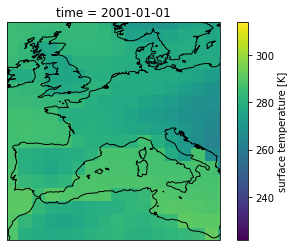

In [21]:
import cartopy.crs as ccrs
import xarray as xr
tsurf_orig = xr.open_dataset(infile).tsurf[0,:,:]

data = tsurf_orig.plot(subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor='gray'), transform=ccrs.PlateCarree(),)

data.axes.set_extent([-10.,20.,30.,60.])
data.axes.coastlines()

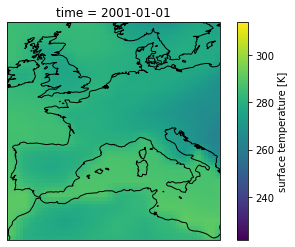

In [22]:
tsurf = cdo.remapbil('r720x360', input='-seltimestep,1 '+infile, returnXArray='tsurf')

data = tsurf.plot(subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor='gray'), transform=ccrs.PlateCarree(),)

data.axes.set_extent([-10.,20.,30.,60.])
data.axes.coastlines()

<br>

## Remap data to a grid of another file

In [23]:
cdo.topo(options='-f nc', output='topo.nc')

tsurf_2 = cdo.remapbil('topo.nc', input="-seltimestep,1 "+infile, returnXArray='tsurf')

<br>

## Create a land-sea mask

CDO provides a global 0.5 degree topography dataset that can be used to generate a land sea mask. First, we interpolate the topography data to the same grid as the data file. With the operator `gtc` we set all values greater than 0.5 m to 1 and all other values to 0.

In [24]:
lsm = cdo.gtc(0.5, input='-remapbil,'+infile+' -topo', returnXArray='topo')
print(lsm)

<xarray.DataArray 'topo' (lat: 96, lon: 192)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -180.0 -178.1 -176.2 -174.4 ... 174.4 176.2 178.1
  * lat      (lat) float64 88.57 86.72 84.86 83.0 ... -83.0 -84.86 -86.72 -88.57
Attributes:
    units:          m
    CDI_grid_type:  gaussian


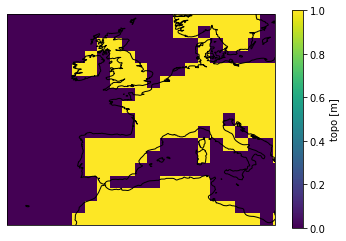

In [25]:
p = lsm.plot(subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor='gray'), transform=ccrs.PlateCarree(),)
p.axes.set_extent([-20.,20.,30.,60.])
p.axes.coastlines()

<br>

## Masking data

Before we can use a mask on a data variable we need to create a mask file using the same grid as the data variable.

In [26]:
cdo.setname('lsm', input='-gtc,0.5 -remapbil,'+infile+' -topo', options='-f nc', output='lsm.nc')

'lsm.nc'

Now, we want to get only tsurf values over land for timestep 1.

In [27]:
masked = cdo.setctomiss(0, input='-mul lsm.nc -seltimestep,1 '+infile, returnXArray='tsurf')

Let's see how it looks like.

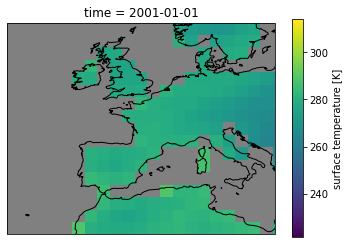

In [28]:
p = masked.plot(subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor='gray'), transform=ccrs.PlateCarree(),)
p.axes.set_extent([-20.,20.,30.,60.])
p.axes.coastlines()

Use a variables instead of output files.

In [29]:
lsm = cdo.setname('lsm', input='-gtc,0.5 -remapbil,'+infile+' -topo', options='-f nc', returnXArray='lsm')

In [30]:
tsurf = cdo.seltimestep(1, input='-selvar,tsurf '+infile, returnXArray='tsurf')

In [31]:
masked = tsurf * lsm
print(masked)

<xarray.DataArray (time: 1, lat: 96, lon: 192)>
array([[[  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        ...,
        [256.27307, 256.78674, 257.43127, ..., 254.5895 , 255.06606,
         255.69496],
        [242.54457, 242.53676, 242.91371, ..., 241.52113, 241.91566,
         242.33168],
        [236.11879, 235.98012, 235.96059, ..., 236.11488, 236.09145,
         236.07191]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01
  * lon      (lon) float64 -180.0 -178.1 -176.2 -174.4 ... 174.4 176.2 178.1
  * lat      (lat) float64 88.57 86.72 84.86 83.0 ... -83.0 -84.86 -86.72 -88.57


Plot the masked data.

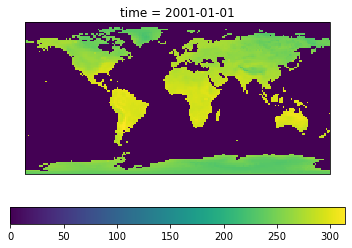

In [32]:
masked.plot(subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor='gray'), transform=ccrs.PlateCarree(),
           cbar_kwargs={'orientation': 'horizontal'})
p.axes.set_extent([-20.,20.,30.,60.])
p.axes.coastlines()  

And now we want to mask the land part of the data. The easiest way is to set all zeros to one and all ones to NaN. Matplotlib will automatically use the color _grey_ for the missing values.

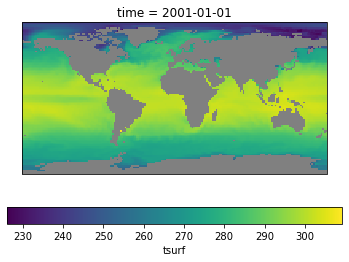

In [33]:
import numpy as np
import matplotlib as mpl
import copy

lsm = np.where(lsm==0, 1, np.nan)

masked = tsurf * lsm

masked.plot(subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor='gray'), transform=ccrs.PlateCarree(),
           cbar_kwargs={'orientation': 'horizontal'})
p.axes.set_extent([-20.,20.,30.,60.])
p.axes.coastlines()

<br>

## Delete temporary files

In [ ]:
cdo.cleanTempDir()

More data analysis packages:
* iris: https://scitools-iris.readthedocs.io/en/stable [example gallery](https://scitools-iris.readthedocs.io/en/stable/generated/gallery/index.html#sphx-glr-generated-gallery)
* SciPy: https://www.scipy.org/docs.html
* geocat: https://geocat.ucar.edu [example gallery](https://geocat-examples.readthedocs.io/en/latest/gallery/index.html)
* seaborn: https://seaborn.pydata.org [example gallery](https://seaborn.pydata.org/examples/index.html)
